# Data Exploration / Testing Algorithms

Dataset: https://snap.stanford.edu/data/soc-RedditHyperlinks.html

Political subreddits list: https://github.com/valentinhofmann/politosphere/blob/main/data/subreddits.txt


## Dataset information
- **SOURCE_SUBREDDIT**: the subreddit where the link originates
- **TARGET_SUBREDDIT**: the subreddit where the link ends
- **POST_ID**: the post in the source subreddit that starts the link
- **TIMESTAMP**: time time of the post
- **POST_LABEL**: label indicating if the source post is explicitly negative towards the target post. The value is -1 if the source is negative towards the target, and 1 if it is neutral or positive. The label is created using crowd-sourcing and training a text based classifier, and is better than simple sentiment analysis of the posts. Please see the reference paper for details.
- **POST_PROPERTIES**: a vector representing the text properties of the source post, listed as a list of comma separated numbers. The vector elements are the following:
1. Number of characters
2. Number of characters without counting white space
3. Fraction of alphabetical characters
4. Fraction of digits
5. Fraction of uppercase characters
6. Fraction of white spaces
7. Fraction of special characters, such as comma, exclamation mark, etc.
8. Number of words
9. Number of unique works
10. Number of long words (at least 6 characters)
11. Average word length
12. Number of unique stopwords
13. Fraction of stopwords
14. Number of sentences
15. Number of long sentences (at least 10 words)
16. Average number of characters per sentence
17. Average number of words per sentence
18. Automated readability index
19. Positive sentiment calculated by VADER
20. Negative sentiment calculated by VADER
21. Compound sentiment calculated by VADER

22-86. LIWC Variables

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.cluster import SpectralClustering

In [2]:
# load the data
network_file = "data/soc-redditHyperlinks-body.tsv"
political_file = "data/subreddits.txt"

df_full = pd.read_csv(network_file, sep="\t")

# filter by political subreddits
# read in political subs
with open('data/subreddits.txt', 'r') as f:
    political_subs = f.readlines()
political_subs = [sub.rstrip('\n') for sub in political_subs]
print("POLITICAL SUBREDDITS:")
print(political_subs[:20])
print()

# filter dataframe 
source_is_political = df_full["SOURCE_SUBREDDIT"].isin(political_subs)
target_is_political = df_full["TARGET_SUBREDDIT"].isin(political_subs)
df = df_full[source_is_political | target_is_political]
df.head()

POLITICAL SUBREDDITS:
['2012Elections', '2016Elections', '2016_elections', '2ALiberals', 'AOC', 'Abortiondebate', 'ActiveMeasures', 'AgainstHateSubreddits', 'AgainstTheChimpire', 'Agorism', 'Albertapolitics', 'AlexandriaOcasio', 'AltRightChristian', 'AmalaNetwork', 'AmericanPolitics', 'AnCap101', 'Anarchism', 'AnarchismOnline', 'AnarchistNews', 'Anarcho_Capitalism']



,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
49,badhistory,worldpolitics,1u6zefs,2014-01-01 18:22:33,1,"2796.0,2433.0,0.775751072961,0.0125178826896,0..."
162,conspiracy,conspiratocracy,1ua18ms,2014-01-02 18:06:25,1,"110.0,110.0,0.8,0.0181818181818,0.036363636363..."
266,metanarchism,anarchism,1ucvjvs,2014-01-03 18:40:01,1,"706.0,620.0,0.781869688385,0.0070821529745,0.0..."
348,shitstatistssay,politics,1uewmys,2014-01-04 12:44:19,1,"112.0,112.0,0.785714285714,0.0267857142857,0.0..."
380,goodshillhunting,metanarchism,1ufkuqs,2014-01-07 00:48:45,1,"697.0,639.0,0.780487804878,0.00860832137733,0...."


In [3]:
source = "SOURCE_SUBREDDIT"
target = "TARGET_SUBREDDIT"
edgelist = df.loc[:, [source, target]].copy()
edgelist_df = edgelist.drop_duplicates().copy()
edgelist_df["count"] = edgelist.groupby([source, target]).transform("size")
# create graph
G = nx.from_pandas_edgelist(edgelist_df, source=source, target=target, create_using=nx.DiGraph(),edge_attr="count")
# convert to adjacency matrix
adj_matrix = nx.to_pandas_adjacency(G, weight="count")
adj_matrix

,badhistory,worldpolitics,conspiracy,conspiratocracy,metanarchism,anarchism,shitstatistssay,politics,goodshillhunting,worldnews,...,marchforscience,academicpsychology,labour2017,remindme,hamiltonmusical,sikh,vault11,pussypass,activemeasures,rs2vietnam
badhistory,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
worldpolitics,0.0,0.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
conspiracy,0.0,10.0,0.0,1.0,0.0,0.0,0.0,64.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
conspiratocracy,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
metanarchism,0.0,1.0,4.0,0.0,0.0,115.0,1.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sikh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vault11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pussypass,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
activemeasures,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Louvain Community Detection

In [4]:
# Louvain communities
communities = nx.community.louvain_communities(G, seed=123)
print(f"Number of communities detected by Louvain: {len(communities)}")
print("Community lengths:",[len(comm) for comm in communities])

print("-"*30)
print("OUTLIERS:",communities[-2:])

Number of communities detected by Louvain: 16
Community lengths: [110, 55, 99, 37, 92, 67, 32, 82, 47, 108, 239, 114, 30, 103, 2, 2]
------------------------------
OUTLIERS: [{'antifa', 'enoughantifaspam'}, {'npr', 'overpopulation'}]


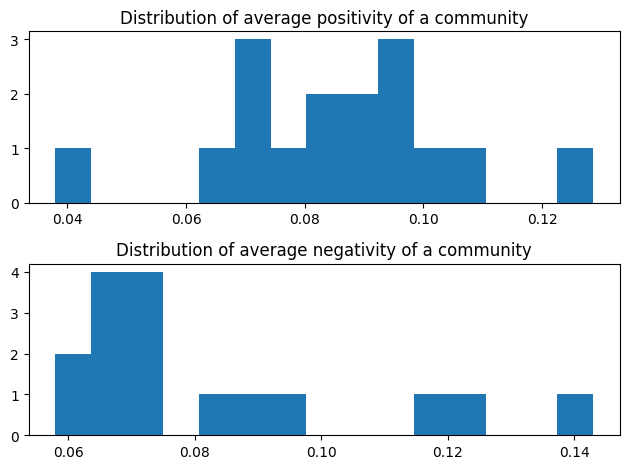

In [51]:
# calculate average positivity and negativity of louvain communities
community_positive_avg = []
community_negative_avg = []

for i, community in enumerate(communities):
    positives = []
    negatives = []
    community_df = df[df[source].isin(community)]
    
    properties = community_df["PROPERTIES"].str.split(',')
    positive = properties.apply(lambda x: float(x[18])).mean().item()
    negative = properties.apply(lambda x: float(x[19])).mean().item()

    community_positive_avg.append(positive)
    community_negative_avg.append(negative)

# plots
fig, ax = plt.subplots(2,1)
ax[0].hist(community_positive_avg, bins=15)
ax[0].set_title("Distribution of average positivity of a community")
ax[1].hist(community_negative_avg, bins=15)
ax[1].set_title("Distribution of average negativity of a community")
plt.tight_layout()
plt.show()

### Spectral Clustering

/Users/katherinehunter/Github/stat236-subreddit-clustering/.venv/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


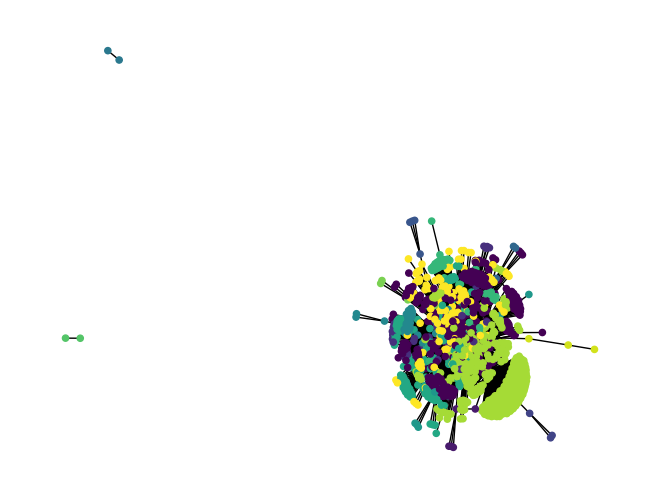

In [5]:
# PLOT SPECTRAL CLUSTERING
undirected_G = G.to_undirected()
A = nx.to_numpy_array(undirected_G)

# Apply spectral clustering to undirected graph
sc = SpectralClustering(n_clusters=16, affinity='precomputed', assign_labels='discretize')
labels = sc.fit_predict(A)

# Add labels to the graph nodes
nx.set_node_attributes(undirected_G, dict(zip(undirected_G.nodes(), labels)), 'cluster')

# Visualize the graph with clusters
nx.draw(undirected_G, node_color=[c for c in labels], 
        with_labels=False,
       node_size=20)

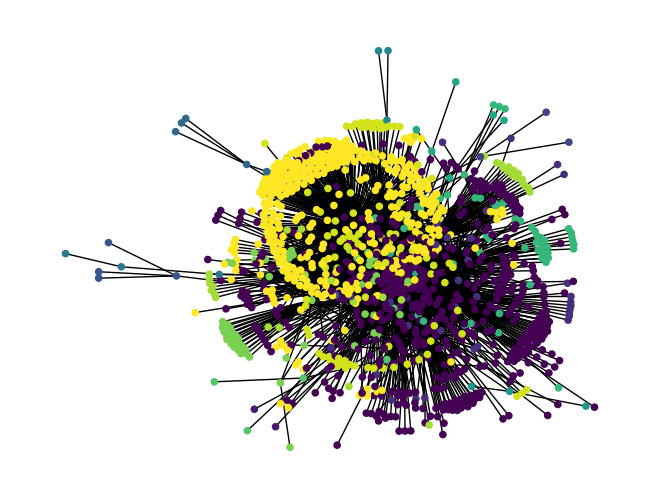

In [6]:
# REMOVE OUTLIERS AND PLOT SPECTRAL CLUSTERING - note: G is redefined to be the undirected graph (edit later)

# get edge list
source = "SOURCE_SUBREDDIT"
target = "TARGET_SUBREDDIT"
edgelist = df.loc[:, [source, target]].copy()

# remove outliers
outliers = ['antifa', 'enoughantifaspam', 'npr', 'overpopulation']
outlier_idx = df[source].isin(outliers) | df[target].isin(outliers)
edgelist = edgelist[~outlier_idx]

edgelist_df = edgelist.drop_duplicates().copy()
edgelist_df["count"] = edgelist.groupby([source, target]).transform("size")
# create undirected graph
G = nx.from_pandas_edgelist(edgelist_df, 
                            source=source, 
                            target=target, 
                            create_using=nx.Graph(),
                            edge_attr="count")
# get adjacency matrix
A = nx.to_numpy_array(G)

# Apply spectral clustering to undirected graph
sc = SpectralClustering(n_clusters=16, affinity='precomputed', assign_labels='discretize')
labels = sc.fit_predict(A)

# Add labels to the graph nodes
nx.set_node_attributes(G, dict(zip(G.nodes(), labels)), 'cluster')

# Visualize the graph with clusters
pos = nx.spring_layout(G, k=0.1, iterations=50)
nx.draw(G, pos, node_color=[c for c in labels], 
        with_labels=False,
       node_size=20)
